In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import copy
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings(action='ignore')
from epftoolbox.evaluation import MAE, sMAPE

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LEAR

In [2]:
df = pd.read_csv("Data\EPFToolbox\FR.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [5]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2011-01-09 00:00:00,32.542,63065.0,63000.0,2011-01-09,0
1,2011-01-09 01:00:00,21.549,62715.0,58800.0,2011-01-09,1
2,2011-01-09 02:00:00,15.711,61952.0,58500.0,2011-01-09,2
3,2011-01-09 03:00:00,10.583,59262.0,54300.0,2011-01-09,3
4,2011-01-09 04:00:00,10.324,56883.0,51900.0,2011-01-09,4
...,...,...,...,...,...,...
52411,2016-12-31 19:00:00,69.720,70329.0,73957.0,2016-12-31,19
52412,2016-12-31 20:00:00,57.100,69121.0,72544.0,2016-12-31,20
52413,2016-12-31 21:00:00,54.490,66647.0,69451.0,2016-12-31,21
52414,2016-12-31 22:00:00,54.950,65886.0,67823.0,2016-12-31,22


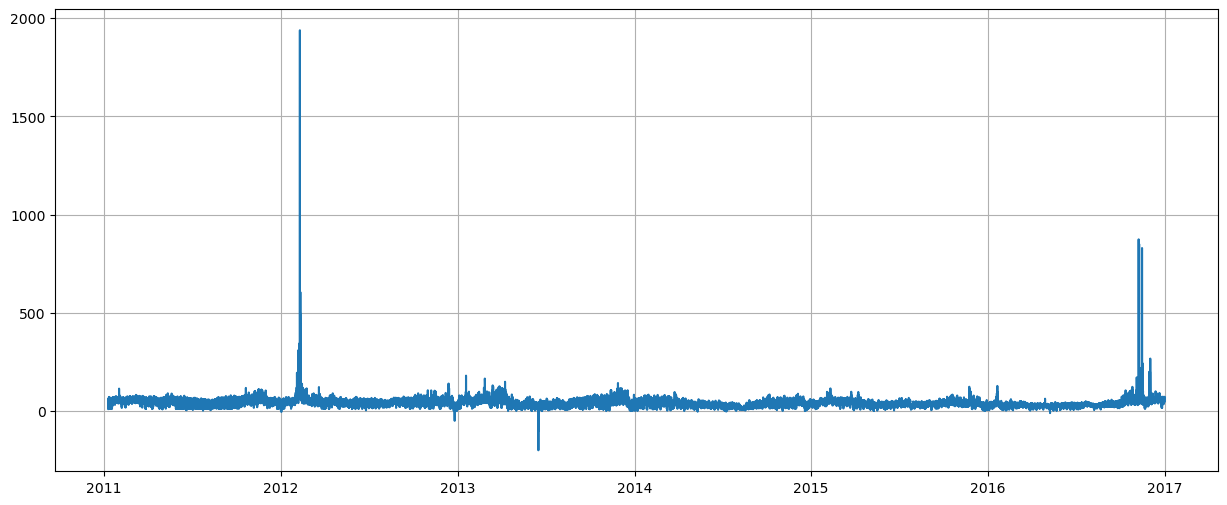

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [7]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [8]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [9]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

# df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

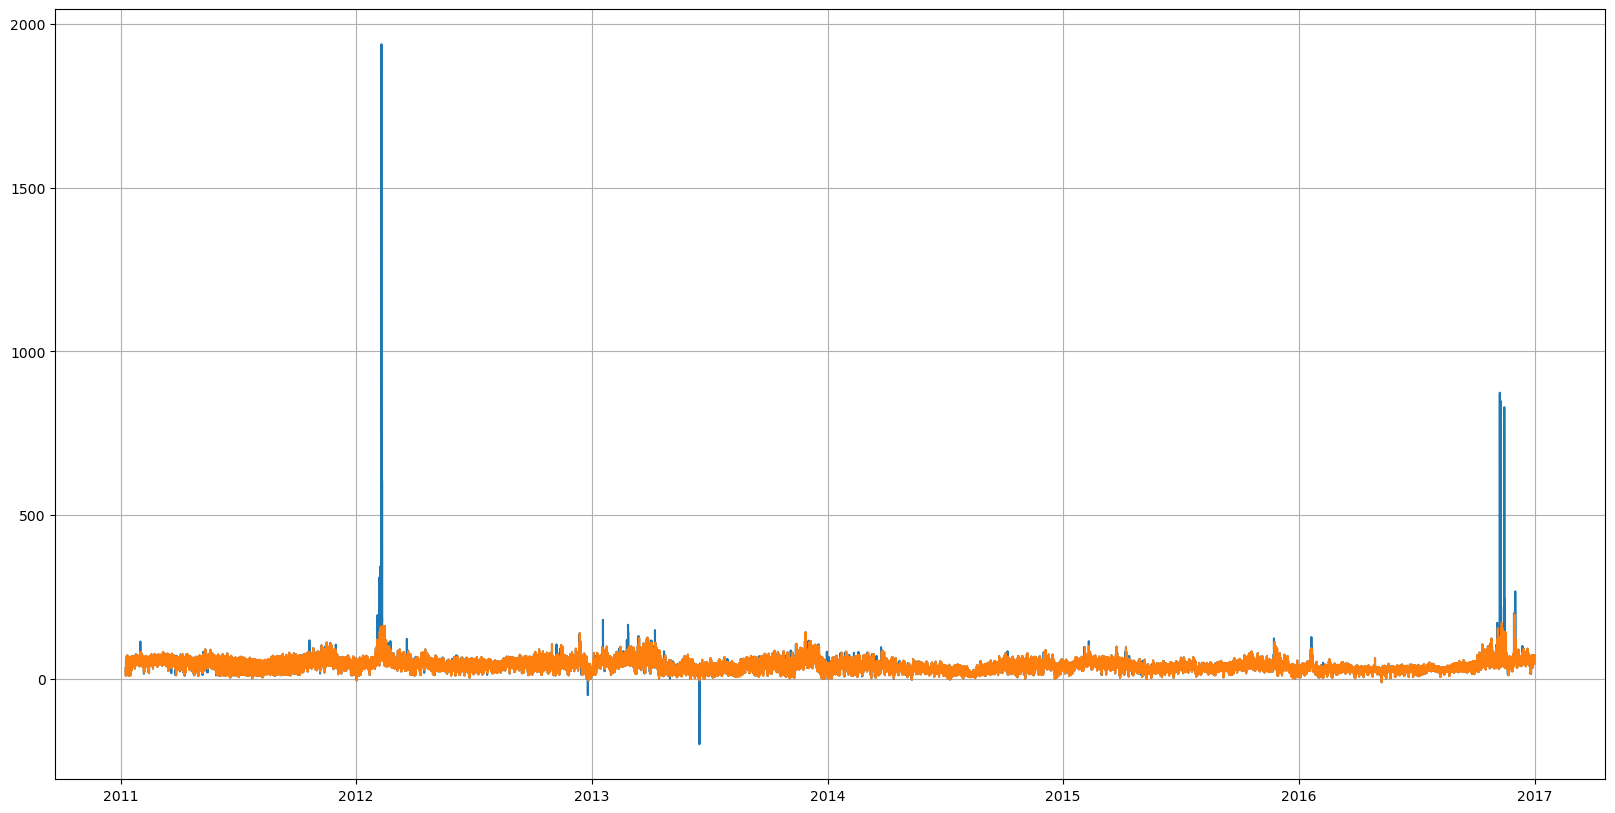

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [11]:
df = df[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [12]:
df.index = df.Date

In [13]:
df = df.drop(['Date'], axis = 1)

In [14]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [15]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [16]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [17]:
forecast_dates = forecast.index

In [18]:
from epftoolbox.models import LEAR

In [19]:
calibration_window = 2*364

In [20]:
model = LEAR(calibration_window=calibration_window)

In [21]:
df_original = pd.read_csv(r"Data\EPFToolbox\FR.csv")

In [22]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [23]:
df_original.index = df_original.Date

In [24]:
df_original = df_original.drop('Date', axis = 1)

In [25]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [26]:
df_original = df_original[df_original.index >= dt.datetime(2015, 1, 1)]

In [27]:
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [28]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,53.48,51.93,48.76,42.27,38.41,35.72,32.66,32.83,30.06,29.24,...,33.29,32.47,34.73,40.95,51.25,52.55,49.55,46.31,48.75,47.59
2015-01-02,38.80,36.73,33.52,27.50,22.84,26.10,27.17,33.33,42.06,46.13,...,41.00,39.78,39.73,50.24,54.10,53.13,48.81,42.99,48.76,48.45
2015-01-03,46.97,43.27,41.76,37.54,32.99,31.24,36.71,39.47,44.51,44.45,...,39.60,35.48,33.85,45.96,49.82,47.62,43.79,42.44,42.03,40.91
2015-01-04,36.26,32.28,27.63,23.94,15.69,18.14,20.03,19.23,27.31,34.54,...,32.68,25.25,30.43,43.04,54.35,51.57,49.99,41.18,44.79,42.96
2015-01-05,36.56,34.94,32.19,23.53,22.92,34.26,44.28,50.38,53.79,52.03,...,42.00,43.10,46.70,56.78,58.84,53.60,46.90,44.58,48.70,46.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,49.97,46.74,44.82,43.42,42.01,45.76,52.87,59.98,67.90,69.14,...,51.27,51.82,54.65,69.99,72.89,72.15,58.60,51.48,51.27,51.48
2016-12-28,48.31,45.76,43.03,40.46,39.34,40.83,44.80,51.00,53.00,56.90,...,50.77,51.60,55.20,63.28,63.70,59.82,62.36,50.00,49.02,47.73
2016-12-29,42.40,39.30,36.83,34.11,34.99,37.64,47.30,51.27,57.42,58.03,...,49.60,51.63,54.43,63.95,67.17,66.40,59.41,51.72,56.44,55.20


In [29]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 14.37%  |  MAE: 5.667
2015-01-02 - sMAPE: 11.32%  |  MAE: 4.332
2015-01-03 - sMAPE: 10.12%  |  MAE: 3.859
2015-01-04 - sMAPE: 10.90%  |  MAE: 3.832
2015-01-05 - sMAPE: 10.32%  |  MAE: 3.830
2015-01-06 - sMAPE: 10.64%  |  MAE: 4.105
2015-01-07 - sMAPE: 9.88%  |  MAE: 3.866
2015-01-08 - sMAPE: 9.23%  |  MAE: 3.624
2015-01-09 - sMAPE: 10.35%  |  MAE: 3.957
2015-01-10 - sMAPE: 13.00%  |  MAE: 4.339
2015-01-11 - sMAPE: 14.32%  |  MAE: 4.383
2015-01-12 - sMAPE: 13.78%  |  MAE: 4.254
2015-01-13 - sMAPE: 13.41%  |  MAE: 4.135
2015-01-14 - sMAPE: 12.99%  |  MAE: 4.023
2015-01-15 - sMAPE: 12.78%  |  MAE: 3.946
2015-01-16 - sMAPE: 12.92%  |  MAE: 4.046
2015-01-17 - sMAPE: 12.59%  |  MAE: 3.957
2015-01-18 - sMAPE: 12.53%  |  MAE: 3.954
2015-01-19 - sMAPE: 12.14%  |  MAE: 3.865
2015-01-20 - sMAPE: 11.88%  |  MAE: 3.822
2015-01-21 - sMAPE: 11.79%  |  MAE: 3.846
2015-01-22 - sMAPE: 11.66%  |  MAE: 3.862
2015-01-23 - sMAPE: 11.47%  |  MAE: 3.842
2015-01-24 - sMAPE: 11.43%  |  MAE: 

2015-07-16 - sMAPE: 13.06%  |  MAE: 4.420
2015-07-17 - sMAPE: 13.03%  |  MAE: 4.412
2015-07-18 - sMAPE: 13.01%  |  MAE: 4.409
2015-07-19 - sMAPE: 13.01%  |  MAE: 4.407
2015-07-20 - sMAPE: 12.99%  |  MAE: 4.404
2015-07-21 - sMAPE: 13.01%  |  MAE: 4.422
2015-07-22 - sMAPE: 12.98%  |  MAE: 4.416
2015-07-23 - sMAPE: 12.95%  |  MAE: 4.409
2015-07-24 - sMAPE: 12.91%  |  MAE: 4.400
2015-07-25 - sMAPE: 13.12%  |  MAE: 4.456
2015-07-26 - sMAPE: 13.35%  |  MAE: 4.506
2015-07-27 - sMAPE: 13.46%  |  MAE: 4.536
2015-07-28 - sMAPE: 13.50%  |  MAE: 4.546
2015-07-29 - sMAPE: 13.47%  |  MAE: 4.536
2015-07-30 - sMAPE: 13.48%  |  MAE: 4.538
2015-07-31 - sMAPE: 13.46%  |  MAE: 4.530
2015-08-01 - sMAPE: 13.47%  |  MAE: 4.529
2015-08-02 - sMAPE: 13.47%  |  MAE: 4.517
2015-08-03 - sMAPE: 13.46%  |  MAE: 4.510
2015-08-04 - sMAPE: 13.45%  |  MAE: 4.507
2015-08-05 - sMAPE: 13.42%  |  MAE: 4.499
2015-08-06 - sMAPE: 13.38%  |  MAE: 4.486
2015-08-07 - sMAPE: 13.34%  |  MAE: 4.475
2015-08-08 - sMAPE: 13.34%  |  MAE

2016-01-28 - sMAPE: 12.85%  |  MAE: 4.359
2016-01-29 - sMAPE: 12.85%  |  MAE: 4.358
2016-01-30 - sMAPE: 12.88%  |  MAE: 4.361
2016-01-31 - sMAPE: 13.00%  |  MAE: 4.366
2016-02-01 - sMAPE: 13.03%  |  MAE: 4.370
2016-02-02 - sMAPE: 13.05%  |  MAE: 4.370
2016-02-03 - sMAPE: 13.07%  |  MAE: 4.373
2016-02-04 - sMAPE: 13.08%  |  MAE: 4.374
2016-02-05 - sMAPE: 13.07%  |  MAE: 4.370
2016-02-06 - sMAPE: 13.09%  |  MAE: 4.367
2016-02-07 - sMAPE: 13.22%  |  MAE: 4.374
2016-02-08 - sMAPE: 13.29%  |  MAE: 4.386
2016-02-09 - sMAPE: 13.30%  |  MAE: 4.384
2016-02-10 - sMAPE: 13.29%  |  MAE: 4.381
2016-02-11 - sMAPE: 13.28%  |  MAE: 4.376
2016-02-12 - sMAPE: 13.28%  |  MAE: 4.375
2016-02-13 - sMAPE: 13.27%  |  MAE: 4.371
2016-02-14 - sMAPE: 13.31%  |  MAE: 4.370
2016-02-15 - sMAPE: 13.31%  |  MAE: 4.369
2016-02-16 - sMAPE: 13.31%  |  MAE: 4.368
2016-02-17 - sMAPE: 13.29%  |  MAE: 4.363
2016-02-18 - sMAPE: 13.28%  |  MAE: 4.358
2016-02-19 - sMAPE: 13.27%  |  MAE: 4.356
2016-02-20 - sMAPE: 13.29%  |  MAE

2016-08-11 - sMAPE: 13.59%  |  MAE: 3.948
2016-08-12 - sMAPE: 13.58%  |  MAE: 3.945
2016-08-13 - sMAPE: 13.59%  |  MAE: 3.947
2016-08-14 - sMAPE: 13.60%  |  MAE: 3.946
2016-08-15 - sMAPE: 13.59%  |  MAE: 3.943
2016-08-16 - sMAPE: 13.58%  |  MAE: 3.939
2016-08-17 - sMAPE: 13.56%  |  MAE: 3.935
2016-08-18 - sMAPE: 13.54%  |  MAE: 3.929
2016-08-19 - sMAPE: 13.53%  |  MAE: 3.926
2016-08-20 - sMAPE: 13.53%  |  MAE: 3.925
2016-08-21 - sMAPE: 13.57%  |  MAE: 3.928
2016-08-22 - sMAPE: 13.56%  |  MAE: 3.926
2016-08-23 - sMAPE: 13.55%  |  MAE: 3.922
2016-08-24 - sMAPE: 13.53%  |  MAE: 3.917
2016-08-25 - sMAPE: 13.52%  |  MAE: 3.915
2016-08-26 - sMAPE: 13.51%  |  MAE: 3.912
2016-08-27 - sMAPE: 13.50%  |  MAE: 3.910
2016-08-28 - sMAPE: 13.50%  |  MAE: 3.909
2016-08-29 - sMAPE: 13.50%  |  MAE: 3.911
2016-08-30 - sMAPE: 13.48%  |  MAE: 3.908
2016-08-31 - sMAPE: 13.47%  |  MAE: 3.903
2016-09-01 - sMAPE: 13.45%  |  MAE: 3.900
2016-09-02 - sMAPE: 13.44%  |  MAE: 3.899
2016-09-03 - sMAPE: 13.43%  |  MAE

In [30]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,41.57142,37.580424,34.420406,30.066188,29.340603,31.805812,33.65741,38.552605,41.922896,41.766507,...,39.805433,35.297092,35.487848,44.88501,51.307409,50.579458,46.645566,41.745066,44.948548,44.211191
2015-01-02,41.935411,38.36605,35.499843,30.96692,31.266578,35.016064,36.994497,39.345649,44.559244,45.703564,...,43.274012,40.499323,41.701511,49.361616,58.351215,53.700008,50.775762,46.983433,50.302424,46.894235
2015-01-03,39.688005,35.223145,32.173701,27.604407,26.776973,30.747451,32.706975,39.02711,44.133117,45.071529,...,40.817738,38.195849,38.581698,46.334018,52.615123,49.456515,44.230451,41.59085,44.921098,42.93171
2015-01-04,36.719486,33.824393,31.216282,27.23136,26.145723,26.593394,27.237974,28.522537,35.266384,35.860401,...,36.631891,35.046782,35.505251,43.48084,52.497548,50.846757,45.732599,41.289791,42.946221,41.083271
2015-01-05,36.551449,32.400497,29.456882,24.942572,23.039382,30.877549,40.419696,47.884486,53.181436,56.74448,...,49.456503,46.514113,48.957611,58.051878,66.725901,62.71836,56.475025,48.327109,51.539725,48.543613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,44.561154,38.267796,34.164325,28.205632,27.247472,33.000044,49.828514,56.278713,59.194924,60.084291,...,53.942267,52.398157,54.378821,63.645509,69.289741,68.586782,62.56428,56.813677,55.524683,51.360369
2016-12-28,45.764404,43.250422,40.517224,36.517364,35.985818,39.066214,48.384369,59.09308,62.396928,63.177522,...,52.865934,52.635594,52.532102,63.870388,71.645546,70.008837,61.281709,52.758312,52.30122,49.513972
2016-12-29,43.862676,41.032699,37.428312,34.238685,33.92772,38.009168,48.724184,57.895971,61.183876,61.860235,...,53.450817,53.098068,56.151917,67.02941,72.811811,68.186423,63.0493,52.105252,51.402272,50.324534


In [31]:
forecast.to_csv("Resultados/fr_epftoolbox_final_2_anos_ventana_no_outliers.csv")

In [32]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [33]:
forecast_dates = forecast.index

In [34]:
calibration_window = 1*364

In [35]:
model = LEAR(calibration_window=calibration_window)

In [36]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 16.08%  |  MAE: 6.264
2015-01-02 - sMAPE: 12.00%  |  MAE: 4.650
2015-01-03 - sMAPE: 10.42%  |  MAE: 4.012
2015-01-04 - sMAPE: 10.69%  |  MAE: 3.859
2015-01-05 - sMAPE: 10.20%  |  MAE: 3.859
2015-01-06 - sMAPE: 10.57%  |  MAE: 4.132
2015-01-07 - sMAPE: 10.05%  |  MAE: 3.967
2015-01-08 - sMAPE: 9.39%  |  MAE: 3.703
2015-01-09 - sMAPE: 10.16%  |  MAE: 3.904
2015-01-10 - sMAPE: 12.88%  |  MAE: 4.285
2015-01-11 - sMAPE: 13.47%  |  MAE: 4.237
2015-01-12 - sMAPE: 12.88%  |  MAE: 4.059
2015-01-13 - sMAPE: 12.60%  |  MAE: 3.961
2015-01-14 - sMAPE: 12.34%  |  MAE: 3.899
2015-01-15 - sMAPE: 12.16%  |  MAE: 3.821
2015-01-16 - sMAPE: 12.31%  |  MAE: 3.919
2015-01-17 - sMAPE: 12.08%  |  MAE: 3.859
2015-01-18 - sMAPE: 12.04%  |  MAE: 3.858
2015-01-19 - sMAPE: 11.70%  |  MAE: 3.785
2015-01-20 - sMAPE: 11.48%  |  MAE: 3.754
2015-01-21 - sMAPE: 11.46%  |  MAE: 3.801
2015-01-22 - sMAPE: 11.51%  |  MAE: 3.886
2015-01-23 - sMAPE: 11.31%  |  MAE: 3.851
2015-01-24 - sMAPE: 11.22%  |  MAE:

2015-07-17 - sMAPE: 12.81%  |  MAE: 4.357
2015-07-18 - sMAPE: 12.79%  |  MAE: 4.353
2015-07-19 - sMAPE: 12.79%  |  MAE: 4.353
2015-07-20 - sMAPE: 12.78%  |  MAE: 4.352
2015-07-21 - sMAPE: 12.81%  |  MAE: 4.375
2015-07-22 - sMAPE: 12.78%  |  MAE: 4.369
2015-07-23 - sMAPE: 12.75%  |  MAE: 4.364
2015-07-24 - sMAPE: 12.71%  |  MAE: 4.354
2015-07-25 - sMAPE: 12.92%  |  MAE: 4.408
2015-07-26 - sMAPE: 13.13%  |  MAE: 4.450
2015-07-27 - sMAPE: 13.21%  |  MAE: 4.472
2015-07-28 - sMAPE: 13.25%  |  MAE: 4.483
2015-07-29 - sMAPE: 13.23%  |  MAE: 4.472
2015-07-30 - sMAPE: 13.24%  |  MAE: 4.474
2015-07-31 - sMAPE: 13.22%  |  MAE: 4.468
2015-08-01 - sMAPE: 13.25%  |  MAE: 4.473
2015-08-02 - sMAPE: 13.27%  |  MAE: 4.464
2015-08-03 - sMAPE: 13.27%  |  MAE: 4.459
2015-08-04 - sMAPE: 13.25%  |  MAE: 4.455
2015-08-05 - sMAPE: 13.23%  |  MAE: 4.448
2015-08-06 - sMAPE: 13.19%  |  MAE: 4.436
2015-08-07 - sMAPE: 13.16%  |  MAE: 4.426
2015-08-08 - sMAPE: 13.17%  |  MAE: 4.428
2015-08-09 - sMAPE: 13.18%  |  MAE

2016-01-29 - sMAPE: 12.80%  |  MAE: 4.339
2016-01-30 - sMAPE: 12.84%  |  MAE: 4.342
2016-01-31 - sMAPE: 12.98%  |  MAE: 4.351
2016-02-01 - sMAPE: 13.01%  |  MAE: 4.353
2016-02-02 - sMAPE: 13.04%  |  MAE: 4.353
2016-02-03 - sMAPE: 13.06%  |  MAE: 4.357
2016-02-04 - sMAPE: 13.07%  |  MAE: 4.359
2016-02-05 - sMAPE: 13.06%  |  MAE: 4.355
2016-02-06 - sMAPE: 13.08%  |  MAE: 4.351
2016-02-07 - sMAPE: 13.29%  |  MAE: 4.363
2016-02-08 - sMAPE: 13.36%  |  MAE: 4.371
2016-02-09 - sMAPE: 13.36%  |  MAE: 4.369
2016-02-10 - sMAPE: 13.35%  |  MAE: 4.365
2016-02-11 - sMAPE: 13.33%  |  MAE: 4.358
2016-02-12 - sMAPE: 13.33%  |  MAE: 4.358
2016-02-13 - sMAPE: 13.33%  |  MAE: 4.354
2016-02-14 - sMAPE: 13.36%  |  MAE: 4.352
2016-02-15 - sMAPE: 13.36%  |  MAE: 4.349
2016-02-16 - sMAPE: 13.36%  |  MAE: 4.349
2016-02-17 - sMAPE: 13.35%  |  MAE: 4.346
2016-02-18 - sMAPE: 13.33%  |  MAE: 4.340
2016-02-19 - sMAPE: 13.32%  |  MAE: 4.338
2016-02-20 - sMAPE: 13.35%  |  MAE: 4.339
2016-02-21 - sMAPE: 13.59%  |  MAE

2016-08-12 - sMAPE: 13.50%  |  MAE: 3.923
2016-08-13 - sMAPE: 13.51%  |  MAE: 3.923
2016-08-14 - sMAPE: 13.51%  |  MAE: 3.921
2016-08-15 - sMAPE: 13.50%  |  MAE: 3.918
2016-08-16 - sMAPE: 13.49%  |  MAE: 3.914
2016-08-17 - sMAPE: 13.47%  |  MAE: 3.911
2016-08-18 - sMAPE: 13.46%  |  MAE: 3.906
2016-08-19 - sMAPE: 13.44%  |  MAE: 3.903
2016-08-20 - sMAPE: 13.45%  |  MAE: 3.903
2016-08-21 - sMAPE: 13.50%  |  MAE: 3.908
2016-08-22 - sMAPE: 13.49%  |  MAE: 3.908
2016-08-23 - sMAPE: 13.48%  |  MAE: 3.905
2016-08-24 - sMAPE: 13.47%  |  MAE: 3.902
2016-08-25 - sMAPE: 13.46%  |  MAE: 3.898
2016-08-26 - sMAPE: 13.45%  |  MAE: 3.897
2016-08-27 - sMAPE: 13.44%  |  MAE: 3.894
2016-08-28 - sMAPE: 13.44%  |  MAE: 3.895
2016-08-29 - sMAPE: 13.45%  |  MAE: 3.900
2016-08-30 - sMAPE: 13.44%  |  MAE: 3.897
2016-08-31 - sMAPE: 13.42%  |  MAE: 3.893
2016-09-01 - sMAPE: 13.41%  |  MAE: 3.891
2016-09-02 - sMAPE: 13.40%  |  MAE: 3.890
2016-09-03 - sMAPE: 13.40%  |  MAE: 3.888
2016-09-04 - sMAPE: 13.39%  |  MAE

In [37]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,40.922926,36.14226,32.88864,27.919424,27.496484,28.447562,31.46123,37.153925,42.413545,42.993619,...,38.33525,35.002048,35.758238,45.110606,49.355262,51.045068,46.730142,41.438699,44.718813,42.298509
2015-01-02,41.76013,36.931646,33.771548,29.323117,30.855716,29.995694,35.633248,40.873157,44.334498,50.105285,...,43.895663,40.275425,41.385167,50.982981,57.036629,56.693926,52.153126,45.438417,46.371485,45.225753
2015-01-03,40.46437,35.388197,32.163505,30.82617,27.277395,27.926003,31.775778,38.592703,43.734066,46.099339,...,39.124493,36.210073,37.954277,45.883426,52.471654,49.891954,45.143558,40.330955,42.534,40.284318
2015-01-04,35.739487,32.491073,29.599755,25.64704,23.886968,26.194745,22.522654,27.318864,35.924133,39.002688,...,33.161864,31.958932,33.715823,41.583054,49.436676,50.006379,46.014522,40.083246,41.692339,37.356918
2015-01-05,36.685997,32.606309,30.066395,24.164972,24.503902,28.748717,39.221894,44.799904,51.284098,56.904272,...,48.163559,43.80415,45.738529,55.337036,68.612333,62.257375,57.227998,47.960367,49.573488,47.029791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,43.858507,37.625,33.400251,28.602912,28.539936,35.161615,51.352711,51.865911,53.250806,60.266087,...,55.487988,53.970442,57.794113,66.973467,59.540015,65.928297,62.749149,55.414948,56.090791,50.38024
2016-12-28,47.048227,41.170776,38.632605,35.714118,34.257633,38.131153,45.66566,52.231798,63.375662,62.94501,...,51.480433,47.824344,50.584936,62.078719,69.297579,66.80728,56.821642,52.034919,59.534966,48.218041
2016-12-29,44.422441,41.052609,37.215588,33.965852,32.514813,36.965547,46.622614,58.955051,61.344736,59.381818,...,53.141693,54.157865,58.908443,68.797493,70.034334,69.917876,65.10893,52.916911,57.085653,48.977589


In [38]:
forecast.to_csv("Resultados/fr_epftoolbox_final_1_anos_ventana_no_outliers.csv")

In [29]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [30]:
forecast_dates = forecast.index

In [31]:
calibration_window = 182

In [32]:
model = LEAR(calibration_window=calibration_window)

In [33]:
# For loop over the recalibration dates
for date in forecast_dates:

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 13.40%  |  MAE: 5.158
2015-01-02 - sMAPE: 10.46%  |  MAE: 3.961
2015-01-03 - sMAPE: 9.66%  |  MAE: 3.661
2015-01-04 - sMAPE: 10.02%  |  MAE: 3.574
2015-01-05 - sMAPE: 9.56%  |  MAE: 3.518
2015-01-06 - sMAPE: 9.38%  |  MAE: 3.542
2015-01-07 - sMAPE: 8.88%  |  MAE: 3.390
2015-01-08 - sMAPE: 8.37%  |  MAE: 3.220
2015-01-09 - sMAPE: 9.30%  |  MAE: 3.478
2015-01-10 - sMAPE: 11.16%  |  MAE: 3.675
2015-01-11 - sMAPE: 12.49%  |  MAE: 3.792
2015-01-12 - sMAPE: 12.07%  |  MAE: 3.699
2015-01-13 - sMAPE: 11.80%  |  MAE: 3.612
2015-01-14 - sMAPE: 11.57%  |  MAE: 3.580
2015-01-15 - sMAPE: 11.47%  |  MAE: 3.536
2015-01-16 - sMAPE: 11.67%  |  MAE: 3.655
2015-01-17 - sMAPE: 11.52%  |  MAE: 3.639
2015-01-18 - sMAPE: 11.41%  |  MAE: 3.621
2015-01-19 - sMAPE: 11.10%  |  MAE: 3.557
2015-01-20 - sMAPE: 10.84%  |  MAE: 3.515
2015-01-21 - sMAPE: 10.77%  |  MAE: 3.544
2015-01-22 - sMAPE: 10.65%  |  MAE: 3.558
2015-01-23 - sMAPE: 10.49%  |  MAE: 3.552
2015-01-24 - sMAPE: 10.33%  |  MAE: 3.51

2015-07-17 - sMAPE: 14.18%  |  MAE: 4.842
2015-07-18 - sMAPE: 14.15%  |  MAE: 4.834
2015-07-19 - sMAPE: 14.15%  |  MAE: 4.831
2015-07-20 - sMAPE: 14.13%  |  MAE: 4.828
2015-07-21 - sMAPE: 14.15%  |  MAE: 4.853
2015-07-22 - sMAPE: 14.11%  |  MAE: 4.842
2015-07-23 - sMAPE: 14.09%  |  MAE: 4.840
2015-07-24 - sMAPE: 14.06%  |  MAE: 4.833
2015-07-25 - sMAPE: 14.25%  |  MAE: 4.884
2015-07-26 - sMAPE: 14.42%  |  MAE: 4.911
2015-07-27 - sMAPE: 14.49%  |  MAE: 4.933
2015-07-28 - sMAPE: 14.55%  |  MAE: 4.950
2015-07-29 - sMAPE: 14.55%  |  MAE: 4.945
2015-07-30 - sMAPE: 14.55%  |  MAE: 4.944
2015-07-31 - sMAPE: 14.52%  |  MAE: 4.934
2015-08-01 - sMAPE: 14.51%  |  MAE: 4.925
2015-08-02 - sMAPE: 14.52%  |  MAE: 4.913
2015-08-03 - sMAPE: 14.51%  |  MAE: 4.908
2015-08-04 - sMAPE: 14.51%  |  MAE: 4.907
2015-08-05 - sMAPE: 14.48%  |  MAE: 4.899
2015-08-06 - sMAPE: 14.45%  |  MAE: 4.888
2015-08-07 - sMAPE: 14.41%  |  MAE: 4.876
2015-08-08 - sMAPE: 14.41%  |  MAE: 4.872
2015-08-09 - sMAPE: 14.43%  |  MAE

2016-01-29 - sMAPE: 13.94%  |  MAE: 4.745
2016-01-30 - sMAPE: 13.97%  |  MAE: 4.748
2016-01-31 - sMAPE: 14.04%  |  MAE: 4.749
2016-02-01 - sMAPE: 14.07%  |  MAE: 4.751
2016-02-02 - sMAPE: 14.09%  |  MAE: 4.750
2016-02-03 - sMAPE: 14.11%  |  MAE: 4.751
2016-02-04 - sMAPE: 14.11%  |  MAE: 4.751
2016-02-05 - sMAPE: 14.11%  |  MAE: 4.749
2016-02-06 - sMAPE: 14.11%  |  MAE: 4.744
2016-02-07 - sMAPE: 14.33%  |  MAE: 4.754
2016-02-08 - sMAPE: 14.37%  |  MAE: 4.757
2016-02-09 - sMAPE: 14.36%  |  MAE: 4.752
2016-02-10 - sMAPE: 14.35%  |  MAE: 4.748
2016-02-11 - sMAPE: 14.34%  |  MAE: 4.742
2016-02-12 - sMAPE: 14.33%  |  MAE: 4.740
2016-02-13 - sMAPE: 14.33%  |  MAE: 4.737
2016-02-14 - sMAPE: 14.37%  |  MAE: 4.734
2016-02-15 - sMAPE: 14.36%  |  MAE: 4.729
2016-02-16 - sMAPE: 14.36%  |  MAE: 4.729
2016-02-17 - sMAPE: 14.34%  |  MAE: 4.724
2016-02-18 - sMAPE: 14.32%  |  MAE: 4.718
2016-02-19 - sMAPE: 14.32%  |  MAE: 4.717
2016-02-20 - sMAPE: 14.33%  |  MAE: 4.716
2016-02-21 - sMAPE: 14.57%  |  MAE

2016-08-12 - sMAPE: 14.22%  |  MAE: 4.249
2016-08-13 - sMAPE: 14.23%  |  MAE: 4.250
2016-08-14 - sMAPE: 14.23%  |  MAE: 4.247
2016-08-15 - sMAPE: 14.22%  |  MAE: 4.243
2016-08-16 - sMAPE: 14.21%  |  MAE: 4.240
2016-08-17 - sMAPE: 14.20%  |  MAE: 4.237
2016-08-18 - sMAPE: 14.18%  |  MAE: 4.233
2016-08-19 - sMAPE: 14.18%  |  MAE: 4.232
2016-08-20 - sMAPE: 14.17%  |  MAE: 4.230
2016-08-21 - sMAPE: 14.22%  |  MAE: 4.235
2016-08-22 - sMAPE: 14.22%  |  MAE: 4.234
2016-08-23 - sMAPE: 14.21%  |  MAE: 4.232
2016-08-24 - sMAPE: 14.20%  |  MAE: 4.229
2016-08-25 - sMAPE: 14.19%  |  MAE: 4.225
2016-08-26 - sMAPE: 14.18%  |  MAE: 4.224
2016-08-27 - sMAPE: 14.18%  |  MAE: 4.224
2016-08-28 - sMAPE: 14.18%  |  MAE: 4.223
2016-08-29 - sMAPE: 14.18%  |  MAE: 4.227
2016-08-30 - sMAPE: 14.17%  |  MAE: 4.225
2016-08-31 - sMAPE: 14.16%  |  MAE: 4.224
2016-09-01 - sMAPE: 14.16%  |  MAE: 4.223
2016-09-02 - sMAPE: 14.15%  |  MAE: 4.222
2016-09-03 - sMAPE: 14.14%  |  MAE: 4.219
2016-09-04 - sMAPE: 14.13%  |  MAE

In [34]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.593411,39.196912,34.896985,30.469365,28.578494,29.246562,29.848362,34.001803,36.978141,40.141548,...,41.286862,37.361628,39.112933,46.693934,50.945873,50.92933,48.516254,45.806784,48.147322,47.376744
2015-01-02,43.925052,40.864043,34.307818,30.047308,29.253369,31.285207,33.935635,39.530134,42.711697,44.92291,...,44.682358,40.640069,44.340951,49.418874,54.381121,52.190302,47.951953,44.555238,46.870894,46.278107
2015-01-03,41.531516,39.026101,34.103725,30.12011,29.13358,27.787093,30.250103,35.989398,38.411318,42.242415,...,40.74289,36.792627,38.169054,46.438394,50.174059,48.727109,43.856282,40.673763,43.417039,43.296533
2015-01-04,37.843458,35.590817,30.42131,24.58078,21.928792,23.259337,23.3981,27.825527,33.448738,35.41281,...,37.629499,34.458481,36.141788,43.402813,49.977835,48.832531,45.100805,42.671811,43.433777,41.630391
2015-01-05,37.705866,32.847755,29.371433,23.459275,20.695522,27.919905,34.09604,41.841524,46.03338,54.353928,...,45.823045,43.32041,46.699465,56.72416,61.035158,57.490017,54.145319,45.699593,47.118535,44.495047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,44.504256,37.142427,33.693891,29.75681,28.399886,36.401445,48.081953,50.136019,56.269423,57.080032,...,50.594887,53.505095,57.3374,68.03031,73.512337,50.745457,59.505874,55.064891,53.504727,49.31387
2016-12-28,47.876226,41.688097,40.630639,39.680023,38.945516,39.15145,44.543585,55.053947,60.977024,58.841444,...,53.351124,53.993832,58.17712,69.161075,68.161386,71.643516,64.974962,59.345812,55.690931,51.965133
2016-12-29,45.62775,43.866831,38.944465,36.329079,34.036513,40.45096,46.660922,54.58986,56.664084,60.673825,...,53.052119,54.782701,59.354983,66.998731,81.532026,70.230959,63.897133,57.852984,54.831936,52.605272


In [35]:
forecast.to_csv("Resultados/fr_epftoolbox_final_6_meses_ventana_no_outliers.csv")

# Estandarización móvil + LEAR + No outliers

In [2]:
df = pd.read_csv("Data\EPFToolbox\FR.csv")
# df['Date'] = pd.to_datetime(df.Date)

In [3]:
df['Date'] = pd.to_datetime(df.Date)
df['Simple Date'] = df.Date.dt.strftime("%Y-%m-%d")
df['Hour'] = df.Date.dt.hour

In [4]:
df.columns = ['Date', 'Price', 'Exogenous 1', 'Exogenous 2', 'Simple Date', 'Hour']

In [5]:
df

,Date,Price,Exogenous 1,Exogenous 2,Simple Date,Hour
0,2011-01-09 00:00:00,32.542,63065.0,63000.0,2011-01-09,0
1,2011-01-09 01:00:00,21.549,62715.0,58800.0,2011-01-09,1
2,2011-01-09 02:00:00,15.711,61952.0,58500.0,2011-01-09,2
3,2011-01-09 03:00:00,10.583,59262.0,54300.0,2011-01-09,3
4,2011-01-09 04:00:00,10.324,56883.0,51900.0,2011-01-09,4
...,...,...,...,...,...,...
52411,2016-12-31 19:00:00,69.720,70329.0,73957.0,2016-12-31,19
52412,2016-12-31 20:00:00,57.100,69121.0,72544.0,2016-12-31,20
52413,2016-12-31 21:00:00,54.490,66647.0,69451.0,2016-12-31,21
52414,2016-12-31 22:00:00,54.950,65886.0,67823.0,2016-12-31,22


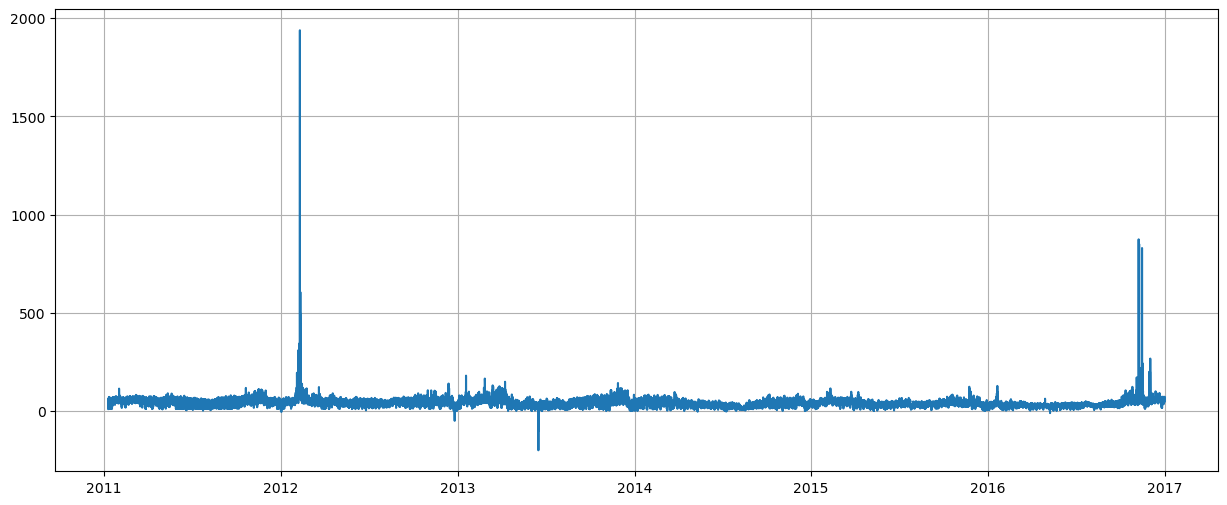

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.grid()

In [7]:
df['Price_no_outliers'] = df.Price

Se añaden variables auxiliares

In [8]:
df['Price_24'] = df.Price.shift(24)
df['Price_48'] = df.Price.shift(48)
df['Price_72'] = df.Price.shift(72)
df['Price_96'] = df.Price.shift(96)
df['Price_120'] = df.Price.shift(120)
df['Price_144'] = df.Price.shift(144)
df['Price_168'] = df.Price.shift(168)

In [9]:
df["diff_Price_24"] = df.Price - df.Price_24
df["lower_quantile_diff_Price_24"] = np.nan
df["upper_quantile_diff_Price_24"] = np.nan
for idx in range(len(df)):
    if idx >= 168:
        df_aux = df.loc[idx - 168 : idx - 1]
        df.loc[idx, "lower_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.025
        )
        df.loc[idx, "upper_quantile_diff_Price_24"] = np.quantile(
            df.diff_Price_24.dropna().to_numpy(), 0.975
        )

df["outlier"] = 0
df.loc[
    (df.diff_Price_24 < df.lower_quantile_diff_Price_24)
    | (df.diff_Price_24 > df.upper_quantile_diff_Price_24),
    "outlier",
] = 1

df["Price_no_outliers"] = df["Price"]
col = df.loc[
    :,
    [
        "Price_24",
        "Price_48",
        "Price_72",
        "Price_96",
        "Price_120",
        "Price_144",
        "Price_168",
    ],
]
df["Price_median"] = col.median(axis=1)
df.loc[df.outlier == 1, "Price_no_outliers"] = df[
    df.outlier == 1
].Price_median

In [10]:
df.outlier.sum()

2614

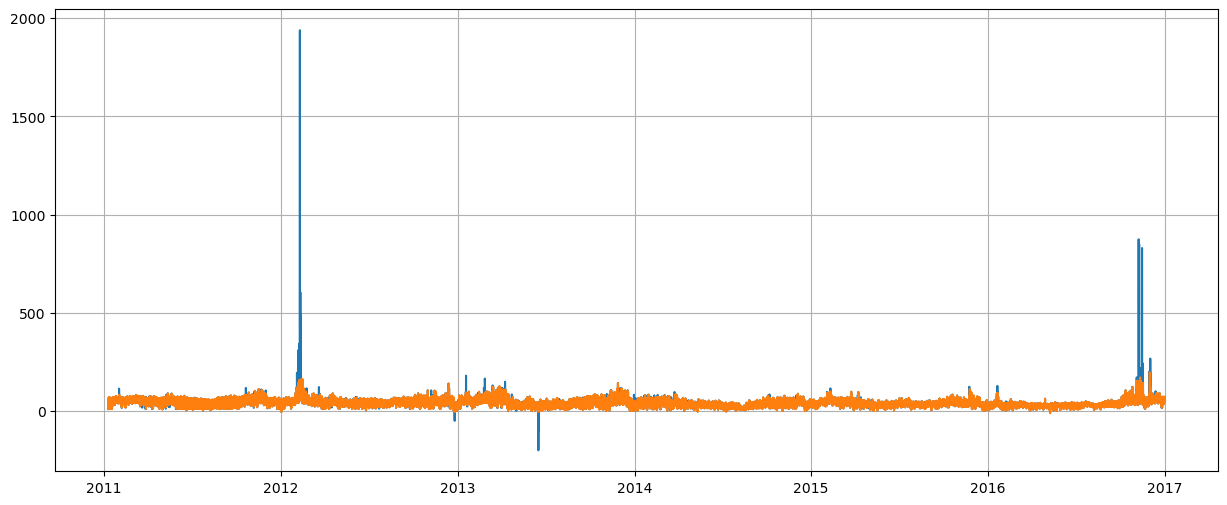

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(df.Date, df.Price)
ax.plot(df.Date, df.Price_no_outliers)
ax.grid()

In [12]:
# names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# for i, x in enumerate(names):
#     df[x] = (pd.to_datetime(df['Simple Date']).dt.weekday == i).astype(int)

In [13]:
# for hora in range(24):
#     df['Price_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Price_hora = df_fecha[df_fecha.Hour == hora].Price.values[0]
        
#         df.loc[df_fecha.index, 'Price_hora_'+str(hora)] = Price_hora

In [14]:
# for col in ['Price_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
#     df[col+"_"+str(48)] = df[col].shift(48)
#     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [15]:
# for hora in range(24):
#     df['Exogenous 1_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_1_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 1'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 1_hora_'+str(hora)] = Exogenous_1_hora

In [16]:
# for hora in range(24):
#     df['Exogenous 2_hora_'+str(hora)] = np.nan

# for fecha in df['Simple Date'].unique():
#     df_fecha = df[df['Simple Date'] == fecha]
    
#     for hora in df_fecha.Hour.unique():
#         Exogenous_2_hora = df_fecha[df_fecha.Hour == hora]['Exogenous 2'].values[0]
        
#         df.loc[df_fecha.index, 'Exogenous 2_hora_'+str(hora)] = Exogenous_2_hora

In [17]:
# for col in ['Exogenous 1_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)
# for col in ['Exogenous 2_hora_'+str(hora) for hora in range(24)]:
#     df[col+"_"+str(24)] = df[col].shift(24)
# #     df[col+"_"+str(48)] = df[col].shift(48)
# #     df[col+"_"+str(72)] = df[col].shift(72)
#     df[col+"_"+str(168)] = df[col].shift(168)

In [18]:
# list(df.columns)

In [12]:
columnas = ['Date',
 'Price',
 'Price_no_outliers',
 'Exogenous 1',
 'Exogenous 2',
 'Simple Date',
 'Hour',
#  'Price_24',
#  'Price_48',
#  'Price_72',
#  'Price_168',
#  'Price_hora_0',
#  'Price_hora_1',
#  'Price_hora_2',
#  'Price_hora_3',
#  'Price_hora_4',
#  'Price_hora_5',
#  'Price_hora_6',
#  'Price_hora_7',
#  'Price_hora_8',
#  'Price_hora_9',
#  'Price_hora_10',
#  'Price_hora_11',
#  'Price_hora_12',
#  'Price_hora_13',
#  'Price_hora_14',
#  'Price_hora_15',
#  'Price_hora_16',
#  'Price_hora_17',
#  'Price_hora_18',
#  'Price_hora_19',
#  'Price_hora_20',
#  'Price_hora_21',
#  'Price_hora_22',
#  'Price_hora_23',
#  'Price_hora_0_24',
#  'Price_hora_0_48',
#  'Price_hora_0_72',
#  'Price_hora_0_168',
#  'Price_hora_1_24',
#  'Price_hora_1_48',
#  'Price_hora_1_72',
#  'Price_hora_1_168',
#  'Price_hora_2_24',
#  'Price_hora_2_48',
#  'Price_hora_2_72',
#  'Price_hora_2_168',
#  'Price_hora_3_24',
#  'Price_hora_3_48',
#  'Price_hora_3_72',
#  'Price_hora_3_168',
#  'Price_hora_4_24',
#  'Price_hora_4_48',
#  'Price_hora_4_72',
#  'Price_hora_4_168',
#  'Price_hora_5_24',
#  'Price_hora_5_48',
#  'Price_hora_5_72',
#  'Price_hora_5_168',
#  'Price_hora_6_24',
#  'Price_hora_6_48',
#  'Price_hora_6_72',
#  'Price_hora_6_168',
#  'Price_hora_7_24',
#  'Price_hora_7_48',
#  'Price_hora_7_72',
#  'Price_hora_7_168',
#  'Price_hora_8_24',
#  'Price_hora_8_48',
#  'Price_hora_8_72',
#  'Price_hora_8_168',
#  'Price_hora_9_24',
#  'Price_hora_9_48',
#  'Price_hora_9_72',
#  'Price_hora_9_168',
#  'Price_hora_10_24',
#  'Price_hora_10_48',
#  'Price_hora_10_72',
#  'Price_hora_10_168',
#  'Price_hora_11_24',
#  'Price_hora_11_48',
#  'Price_hora_11_72',
#  'Price_hora_11_168',
#  'Price_hora_12_24',
#  'Price_hora_12_48',
#  'Price_hora_12_72',
#  'Price_hora_12_168',
#  'Price_hora_13_24',
#  'Price_hora_13_48',
#  'Price_hora_13_72',
#  'Price_hora_13_168',
#  'Price_hora_14_24',
#  'Price_hora_14_48',
#  'Price_hora_14_72',
#  'Price_hora_14_168',
#  'Price_hora_15_24',
#  'Price_hora_15_48',
#  'Price_hora_15_72',
#  'Price_hora_15_168',
#  'Price_hora_16_24',
#  'Price_hora_16_48',
#  'Price_hora_16_72',
#  'Price_hora_16_168',
#  'Price_hora_17_24',
#  'Price_hora_17_48',
#  'Price_hora_17_72',
#  'Price_hora_17_168',
#  'Price_hora_18_24',
#  'Price_hora_18_48',
#  'Price_hora_18_72',
#  'Price_hora_18_168',
#  'Price_hora_19_24',
#  'Price_hora_19_48',
#  'Price_hora_19_72',
#  'Price_hora_19_168',
#  'Price_hora_20_24',
#  'Price_hora_20_48',
#  'Price_hora_20_72',
#  'Price_hora_20_168',
#  'Price_hora_21_24',
#  'Price_hora_21_48',
#  'Price_hora_21_72',
#  'Price_hora_21_168',
#  'Price_hora_22_24',
#  'Price_hora_22_48',
#  'Price_hora_22_72',
#  'Price_hora_22_168',
#  'Price_hora_23_24',
#  'Price_hora_23_48',
#  'Price_hora_23_72',
#  'Price_hora_23_168',
#  'Exogenous 1_hora_0',
#  'Exogenous 1_hora_1',
#  'Exogenous 1_hora_2',
#  'Exogenous 1_hora_3',
#  'Exogenous 1_hora_4',
#  'Exogenous 1_hora_5',
#  'Exogenous 1_hora_6',
#  'Exogenous 1_hora_7',
#  'Exogenous 1_hora_8',
#  'Exogenous 1_hora_9',
#  'Exogenous 1_hora_10',
#  'Exogenous 1_hora_11',
#  'Exogenous 1_hora_12',
#  'Exogenous 1_hora_13',
#  'Exogenous 1_hora_14',
#  'Exogenous 1_hora_15',
#  'Exogenous 1_hora_16',
#  'Exogenous 1_hora_17',
#  'Exogenous 1_hora_18',
#  'Exogenous 1_hora_19',
#  'Exogenous 1_hora_20',
#  'Exogenous 1_hora_21',
#  'Exogenous 1_hora_22',
#  'Exogenous 1_hora_23',
#  'Exogenous 2_hora_0',
#  'Exogenous 2_hora_1',
#  'Exogenous 2_hora_2',
#  'Exogenous 2_hora_3',
#  'Exogenous 2_hora_4',
#  'Exogenous 2_hora_5',
#  'Exogenous 2_hora_6',
#  'Exogenous 2_hora_7',
#  'Exogenous 2_hora_8',
#  'Exogenous 2_hora_9',
#  'Exogenous 2_hora_10',
#  'Exogenous 2_hora_11',
#  'Exogenous 2_hora_12',
#  'Exogenous 2_hora_13',
#  'Exogenous 2_hora_14',
#  'Exogenous 2_hora_15',
#  'Exogenous 2_hora_16',
#  'Exogenous 2_hora_17',
#  'Exogenous 2_hora_18',
#  'Exogenous 2_hora_19',
#  'Exogenous 2_hora_20',
#  'Exogenous 2_hora_21',
#  'Exogenous 2_hora_22',
#  'Exogenous 2_hora_23',
#  'Exogenous 1_hora_0_24',
#  'Exogenous 1_hora_0_168',
#  'Exogenous 1_hora_1_24',
#  'Exogenous 1_hora_1_168',
#  'Exogenous 1_hora_2_24',
#  'Exogenous 1_hora_2_168',
#  'Exogenous 1_hora_3_24',
#  'Exogenous 1_hora_3_168',
#  'Exogenous 1_hora_4_24',
#  'Exogenous 1_hora_4_168',
#  'Exogenous 1_hora_5_24',
#  'Exogenous 1_hora_5_168',
#  'Exogenous 1_hora_6_24',
#  'Exogenous 1_hora_6_168',
#  'Exogenous 1_hora_7_24',
#  'Exogenous 1_hora_7_168',
#  'Exogenous 1_hora_8_24',
#  'Exogenous 1_hora_8_168',
#  'Exogenous 1_hora_9_24',
#  'Exogenous 1_hora_9_168',
#  'Exogenous 1_hora_10_24',
#  'Exogenous 1_hora_10_168',
#  'Exogenous 1_hora_11_24',
#  'Exogenous 1_hora_11_168',
#  'Exogenous 1_hora_12_24',
#  'Exogenous 1_hora_12_168',
#  'Exogenous 1_hora_13_24',
#  'Exogenous 1_hora_13_168',
#  'Exogenous 1_hora_14_24',
#  'Exogenous 1_hora_14_168',
#  'Exogenous 1_hora_15_24',
#  'Exogenous 1_hora_15_168',
#  'Exogenous 1_hora_16_24',
#  'Exogenous 1_hora_16_168',
#  'Exogenous 1_hora_17_24',
#  'Exogenous 1_hora_17_168',
#  'Exogenous 1_hora_18_24',
#  'Exogenous 1_hora_18_168',
#  'Exogenous 1_hora_19_24',
#  'Exogenous 1_hora_19_168',
#  'Exogenous 1_hora_20_24',
#  'Exogenous 1_hora_20_168',
#  'Exogenous 1_hora_21_24',
#  'Exogenous 1_hora_21_168',
#  'Exogenous 1_hora_22_24',
#  'Exogenous 1_hora_22_168',
#  'Exogenous 1_hora_23_24',
#  'Exogenous 1_hora_23_168',
#  'Exogenous 2_hora_0_24',
#  'Exogenous 2_hora_0_168',
#  'Exogenous 2_hora_1_24',
#  'Exogenous 2_hora_1_168',
#  'Exogenous 2_hora_2_24',
#  'Exogenous 2_hora_2_168',
#  'Exogenous 2_hora_3_24',
#  'Exogenous 2_hora_3_168',
#  'Exogenous 2_hora_4_24',
#  'Exogenous 2_hora_4_168',
#  'Exogenous 2_hora_5_24',
#  'Exogenous 2_hora_5_168',
#  'Exogenous 2_hora_6_24',
#  'Exogenous 2_hora_6_168',
#  'Exogenous 2_hora_7_24',
#  'Exogenous 2_hora_7_168',
#  'Exogenous 2_hora_8_24',
#  'Exogenous 2_hora_8_168',
#  'Exogenous 2_hora_9_24',
#  'Exogenous 2_hora_9_168',
#  'Exogenous 2_hora_10_24',
#  'Exogenous 2_hora_10_168',
#  'Exogenous 2_hora_11_24',
#  'Exogenous 2_hora_11_168',
#  'Exogenous 2_hora_12_24',
#  'Exogenous 2_hora_12_168',
#  'Exogenous 2_hora_13_24',
#  'Exogenous 2_hora_13_168',
#  'Exogenous 2_hora_14_24',
#  'Exogenous 2_hora_14_168',
#  'Exogenous 2_hora_15_24',
#  'Exogenous 2_hora_15_168',
#  'Exogenous 2_hora_16_24',
#  'Exogenous 2_hora_16_168',
#  'Exogenous 2_hora_17_24',
#  'Exogenous 2_hora_17_168',
#  'Exogenous 2_hora_18_24',
#  'Exogenous 2_hora_18_168',
#  'Exogenous 2_hora_19_24',
#  'Exogenous 2_hora_19_168',
#  'Exogenous 2_hora_20_24',
#  'Exogenous 2_hora_20_168',
#  'Exogenous 2_hora_21_24',
#  'Exogenous 2_hora_21_168',
#  'Exogenous 2_hora_22_24',
#  'Exogenous 2_hora_22_168',
#  'Exogenous 2_hora_23_24',
#  'Exogenous 2_hora_23_168'
           ]

# columnas_post = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
#        'Saturday', 'Sunday']

In [13]:
def standard_movil(df):
    columnas = list(df.columns)
    dict_new_df = {col: [] for col in columnas}
    columnas.remove('Date')
    columnas.remove('Simple Date')
    columnas.remove('Hour')
    dict_new_df['scaler'] = []
    dict_new_df['scaler_real'] = []
    dict_new_df['Price_real'] = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if index >= 168*1:
            dict_new_df['Date'].append(row.Date)
            dict_new_df['Simple Date'].append(row['Simple Date'])
            dict_new_df['Hour'].append(row.Hour)
            df_aux = df[(pd.to_datetime(df['Simple Date']) < pd.to_datetime(row['Simple Date'])) & (pd.to_datetime(df['Simple Date']) >= pd.to_datetime(row['Simple Date']) - dt.timedelta(days=7))]
            for col in columnas:
                df_aux_col = df_aux[col].to_numpy().reshape(-1, 1)
                scaler = StandardScaler()
                scaler.fit(df_aux_col)
                if col == 'Price':
                    dict_new_df['Price_real'].append(row[col])
                    dict_new_df['scaler_real'].append(scaler)
                elif col == 'Price_no_outliers':
                    dict_new_df['scaler'].append(scaler)
                dict_new_df[col].append(scaler.transform(np.array(row[col]).reshape(1, -1))[0][0])
    return dict_new_df

In [14]:
dict_new_df = standard_movil(df[columnas])

100%|████████████████████████████████████████████████████████████████████████████| 52416/52416 [14:50<00:00, 58.86it/s]


In [15]:
df = df.drop(df.head(168).index)

In [16]:
with open('dict_new_df_fr_epftoolbox_final_no_outliers.pkl', 'wb') as f:
    pickle.dump(dict_new_df, f)

In [24]:
# with open('dict_new_df_espana_epftoolbox_final_no_outliers.pkl', 'rb') as handle:
#     dict_new_df = pickle.load(handle)

In [25]:
for k, v in dict_new_df.items():
    print(k, len(v))

Date 52248
Price 52248
Price_no_outliers 52248
Exogenous 1 52248
Exogenous 2 52248
Simple Date 52248
Hour 52248
scaler 52248
scaler_real 52248
Price_real 52248


In [26]:
df_nuevo = pd.DataFrame(dict_new_df)

In [27]:
df_nuevo

,Date,Price,Price_no_outliers,Exogenous 1,Exogenous 2,Simple Date,Hour,scaler,scaler_real,Price_real
0,2011-01-16 00:00:00,-1.430561,-1.430561,-1.366307,-0.683612,2011-01-16,0,StandardScaler(),StandardScaler(),21.324
1,2011-01-16 01:00:00,-1.592241,-1.592241,-1.542910,-1.205145,2011-01-16,1,StandardScaler(),StandardScaler(),18.542
2,2011-01-16 02:00:00,-1.798670,-1.798670,-1.851123,-1.246318,2011-01-16,2,StandardScaler(),StandardScaler(),14.990
3,2011-01-16 03:00:00,-2.084951,-2.084951,-2.082233,-1.740401,2011-01-16,3,StandardScaler(),StandardScaler(),10.064
4,2011-01-16 04:00:00,-2.076989,-2.076989,-2.401347,-2.083515,2011-01-16,4,StandardScaler(),StandardScaler(),10.201
...,...,...,...,...,...,...,...,...,...,...
52243,2016-12-31 19:00:00,1.653850,1.653850,2.137472,1.785781,2016-12-31,19,StandardScaler(),StandardScaler(),69.720
52244,2016-12-31 20:00:00,0.587117,0.587117,1.882471,1.584519,2016-12-31,20,StandardScaler(),StandardScaler(),57.100
52245,2016-12-31 21:00:00,0.366501,0.366501,1.360225,1.143963,2016-12-31,21,StandardScaler(),StandardScaler(),54.490
52246,2016-12-31 22:00:00,0.405383,0.405383,1.199583,0.912077,2016-12-31,22,StandardScaler(),StandardScaler(),54.950


In [28]:
# for col in columnas_post:
#     df_nuevo[col] = df[col].to_numpy()

In [29]:
df_scalers = pd.DataFrame({'Date':dict_new_df['Date'], 'scaler':dict_new_df['scaler_real']})

In [30]:
df_scalers

,Date,scaler
0,2011-01-16 00:00:00,StandardScaler()
1,2011-01-16 01:00:00,StandardScaler()
2,2011-01-16 02:00:00,StandardScaler()
3,2011-01-16 03:00:00,StandardScaler()
4,2011-01-16 04:00:00,StandardScaler()
...,...,...
52243,2016-12-31 19:00:00,StandardScaler()
52244,2016-12-31 20:00:00,StandardScaler()
52245,2016-12-31 21:00:00,StandardScaler()
52246,2016-12-31 22:00:00,StandardScaler()


In [21]:
df_nuevo = df_nuevo[['Date', 'Price_no_outliers', 'Exogenous 1', 'Exogenous 2']].rename(columns={'Price_no_outliers':'Price'})

In [22]:
df = df_nuevo

In [23]:
df.index = df.Date

In [24]:
df = df.drop(['Date'], axis = 1)

In [25]:
df_train = df[df.index < dt.datetime(2015, 1, 1)]
df_test = df[df.index >= dt.datetime(2015, 1, 1)]

In [26]:
df_test.columns

Index(['Price', 'Exogenous 1', 'Exogenous 2'], dtype='object')

In [27]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
# real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
# real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [28]:
forecast_dates = forecast.index

In [29]:
from epftoolbox.models._lear import LEAR_adaptive_normalization as LEAR

In [30]:
calibration_window = 2*364

In [31]:
model = LEAR(calibration_window=calibration_window)

In [32]:
df_scalers[(df_scalers.Date >= forecast_dates[0]) & (df_scalers.Date <= forecast_dates[0] + pd.Timedelta(hours=23))].scaler.to_numpy()

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler()], dtype=object)

In [33]:
df_original = pd.read_csv(r"Data\EPFToolbox\FR.csv")

In [34]:
df_original['Date'] = pd.to_datetime(df_original.Date)

In [35]:
df_original.index = df_original.Date

In [36]:
df_original = df_original.drop('Date', axis = 1)

In [37]:
df_original.columns = ['Price', 'Exogenous 1', 'Exogenous 2']

In [38]:
df_original = df_original[df_original.index >= dt.datetime(2015, 1, 1)]

In [39]:
real_values = df_original[df_original.index >= dt.datetime(2015, 1, 1)].loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

In [40]:
real_values

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,53.48,51.93,48.76,42.27,38.41,35.72,32.66,32.83,30.06,29.24,...,33.29,32.47,34.73,40.95,51.25,52.55,49.55,46.31,48.75,47.59
2015-01-02,38.80,36.73,33.52,27.50,22.84,26.10,27.17,33.33,42.06,46.13,...,41.00,39.78,39.73,50.24,54.10,53.13,48.81,42.99,48.76,48.45
2015-01-03,46.97,43.27,41.76,37.54,32.99,31.24,36.71,39.47,44.51,44.45,...,39.60,35.48,33.85,45.96,49.82,47.62,43.79,42.44,42.03,40.91
2015-01-04,36.26,32.28,27.63,23.94,15.69,18.14,20.03,19.23,27.31,34.54,...,32.68,25.25,30.43,43.04,54.35,51.57,49.99,41.18,44.79,42.96
2015-01-05,36.56,34.94,32.19,23.53,22.92,34.26,44.28,50.38,53.79,52.03,...,42.00,43.10,46.70,56.78,58.84,53.60,46.90,44.58,48.70,46.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,49.97,46.74,44.82,43.42,42.01,45.76,52.87,59.98,67.90,69.14,...,51.27,51.82,54.65,69.99,72.89,72.15,58.60,51.48,51.27,51.48
2016-12-28,48.31,45.76,43.03,40.46,39.34,40.83,44.80,51.00,53.00,56.90,...,50.77,51.60,55.20,63.28,63.70,59.82,62.36,50.00,49.02,47.73
2016-12-29,42.40,39.30,36.83,34.11,34.99,37.64,47.30,51.27,57.42,58.03,...,49.60,51.63,54.43,63.95,67.17,66.40,59.41,51.72,56.44,55.20


In [18]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

NameError: name 'forecast_dates' is not defined

In [54]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,43.031779,39.919602,39.068151,35.180918,31.853088,30.232561,29.253033,34.468578,34.799548,35.489334,...,35.476028,31.339136,32.832113,41.778386,48.58857,47.476596,44.452995,39.955937,42.736214,42.835735
2015-01-02,42.128967,39.296591,38.121609,33.401858,32.093318,33.376317,35.815096,39.940509,45.195027,48.101417,...,43.094713,39.721614,42.045981,49.372748,56.702892,53.539122,49.830346,45.213892,47.428693,45.118858
2015-01-03,40.313793,36.580866,34.731889,29.411755,26.795652,28.946197,31.627734,37.65293,41.203178,43.299642,...,38.328601,35.428975,36.472645,44.169587,48.461162,48.341451,42.313744,38.084523,42.072592,40.788836
2015-01-04,37.657876,34.324111,31.094964,23.799242,22.816866,26.141557,26.692586,29.645194,35.32329,34.608889,...,32.804945,31.226272,31.495912,42.036899,49.8474,48.772963,45.721839,41.00055,42.32941,40.897046
2015-01-05,38.482727,35.378276,32.958486,26.174357,24.635713,32.037501,41.017199,46.629595,52.275978,55.766303,...,49.828277,48.686656,50.07171,58.708288,66.495164,62.103587,56.093614,50.148549,50.910262,48.106687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,45.226217,40.206281,38.041404,33.601336,31.783342,36.810728,50.185573,56.089168,59.005089,59.596348,...,54.355465,53.631563,54.707198,61.428677,64.688469,66.978606,62.06833,56.364675,56.632836,53.264237
2016-12-28,47.525602,45.067838,43.887218,41.559545,39.980949,42.465877,50.002172,58.5049,61.604757,63.142937,...,53.809244,53.212673,54.321643,62.73852,67.841675,68.864045,62.124411,56.259751,55.804398,53.62236
2016-12-29,45.289866,43.101286,41.564946,39.676658,37.872251,41.101969,50.444087,58.613501,61.379976,61.604512,...,55.427793,55.342906,57.101491,65.022625,72.087923,69.959861,65.034543,57.283093,57.200503,54.848258


In [55]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_fr_epftoolbox_final_2_anos_ventana_no_outliers.csv")

In [56]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [57]:
forecast_dates = forecast.index

In [58]:
calibration_window = 1*364

In [59]:
model = LEAR(calibration_window=calibration_window)

In [60]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 9.26%  |  MAE: 3.812
2015-01-02 - sMAPE: 10.04%  |  MAE: 3.875
2015-01-03 - sMAPE: 9.96%  |  MAE: 3.853
2015-01-04 - sMAPE: 10.29%  |  MAE: 3.772
2015-01-05 - sMAPE: 9.84%  |  MAE: 3.765
2015-01-06 - sMAPE: 9.73%  |  MAE: 3.850
2015-01-07 - sMAPE: 8.91%  |  MAE: 3.552
2015-01-08 - sMAPE: 8.79%  |  MAE: 3.502
2015-01-09 - sMAPE: 9.44%  |  MAE: 3.631
2015-01-10 - sMAPE: 11.59%  |  MAE: 3.887
2015-01-11 - sMAPE: 14.18%  |  MAE: 4.211
2015-01-12 - sMAPE: 13.68%  |  MAE: 4.064
2015-01-13 - sMAPE: 13.33%  |  MAE: 3.954
2015-01-14 - sMAPE: 13.04%  |  MAE: 3.910
2015-01-15 - sMAPE: 12.79%  |  MAE: 3.821
2015-01-16 - sMAPE: 13.23%  |  MAE: 4.012
2015-01-17 - sMAPE: 12.89%  |  MAE: 3.941
2015-01-18 - sMAPE: 12.72%  |  MAE: 3.926
2015-01-19 - sMAPE: 12.33%  |  MAE: 3.857
2015-01-20 - sMAPE: 11.91%  |  MAE: 3.764
2015-01-21 - sMAPE: 11.60%  |  MAE: 3.707
2015-01-22 - sMAPE: 11.37%  |  MAE: 3.700
2015-01-23 - sMAPE: 11.17%  |  MAE: 3.679
2015-01-24 - sMAPE: 10.89%  |  MAE: 3.605

2015-07-17 - sMAPE: 12.17%  |  MAE: 4.119
2015-07-18 - sMAPE: 12.14%  |  MAE: 4.112
2015-07-19 - sMAPE: 12.16%  |  MAE: 4.117
2015-07-20 - sMAPE: 12.13%  |  MAE: 4.112
2015-07-21 - sMAPE: 12.15%  |  MAE: 4.133
2015-07-22 - sMAPE: 12.13%  |  MAE: 4.130
2015-07-23 - sMAPE: 12.10%  |  MAE: 4.124
2015-07-24 - sMAPE: 12.07%  |  MAE: 4.116
2015-07-25 - sMAPE: 12.30%  |  MAE: 4.179
2015-07-26 - sMAPE: 12.50%  |  MAE: 4.217
2015-07-27 - sMAPE: 12.65%  |  MAE: 4.255
2015-07-28 - sMAPE: 12.70%  |  MAE: 4.271
2015-07-29 - sMAPE: 12.71%  |  MAE: 4.272
2015-07-30 - sMAPE: 12.74%  |  MAE: 4.278
2015-07-31 - sMAPE: 12.72%  |  MAE: 4.269
2015-08-01 - sMAPE: 12.74%  |  MAE: 4.267
2015-08-02 - sMAPE: 12.73%  |  MAE: 4.253
2015-08-03 - sMAPE: 12.75%  |  MAE: 4.260
2015-08-04 - sMAPE: 12.77%  |  MAE: 4.267
2015-08-05 - sMAPE: 12.75%  |  MAE: 4.260
2015-08-06 - sMAPE: 12.72%  |  MAE: 4.251
2015-08-07 - sMAPE: 12.69%  |  MAE: 4.242
2015-08-08 - sMAPE: 12.69%  |  MAE: 4.239
2015-08-09 - sMAPE: 12.67%  |  MAE

2016-01-29 - sMAPE: 12.18%  |  MAE: 4.116
2016-01-30 - sMAPE: 12.21%  |  MAE: 4.118
2016-01-31 - sMAPE: 12.24%  |  MAE: 4.115
2016-02-01 - sMAPE: 12.26%  |  MAE: 4.115
2016-02-02 - sMAPE: 12.25%  |  MAE: 4.109
2016-02-03 - sMAPE: 12.25%  |  MAE: 4.105
2016-02-04 - sMAPE: 12.24%  |  MAE: 4.101
2016-02-05 - sMAPE: 12.24%  |  MAE: 4.099
2016-02-06 - sMAPE: 12.25%  |  MAE: 4.096
2016-02-07 - sMAPE: 12.27%  |  MAE: 4.093
2016-02-08 - sMAPE: 12.28%  |  MAE: 4.087
2016-02-09 - sMAPE: 12.27%  |  MAE: 4.082
2016-02-10 - sMAPE: 12.26%  |  MAE: 4.077
2016-02-11 - sMAPE: 12.24%  |  MAE: 4.072
2016-02-12 - sMAPE: 12.24%  |  MAE: 4.070
2016-02-13 - sMAPE: 12.25%  |  MAE: 4.068
2016-02-14 - sMAPE: 12.26%  |  MAE: 4.064
2016-02-15 - sMAPE: 12.26%  |  MAE: 4.059
2016-02-16 - sMAPE: 12.26%  |  MAE: 4.060
2016-02-17 - sMAPE: 12.25%  |  MAE: 4.058
2016-02-18 - sMAPE: 12.24%  |  MAE: 4.053
2016-02-19 - sMAPE: 12.23%  |  MAE: 4.050
2016-02-20 - sMAPE: 12.23%  |  MAE: 4.047
2016-02-21 - sMAPE: 12.28%  |  MAE

2016-08-12 - sMAPE: 11.91%  |  MAE: 3.606
2016-08-13 - sMAPE: 11.91%  |  MAE: 3.603
2016-08-14 - sMAPE: 11.91%  |  MAE: 3.601
2016-08-15 - sMAPE: 11.91%  |  MAE: 3.600
2016-08-16 - sMAPE: 11.90%  |  MAE: 3.595
2016-08-17 - sMAPE: 11.89%  |  MAE: 3.594
2016-08-18 - sMAPE: 11.88%  |  MAE: 3.591
2016-08-19 - sMAPE: 11.87%  |  MAE: 3.589
2016-08-20 - sMAPE: 11.86%  |  MAE: 3.586
2016-08-21 - sMAPE: 11.90%  |  MAE: 3.589
2016-08-22 - sMAPE: 11.89%  |  MAE: 3.585
2016-08-23 - sMAPE: 11.88%  |  MAE: 3.582
2016-08-24 - sMAPE: 11.87%  |  MAE: 3.579
2016-08-25 - sMAPE: 11.86%  |  MAE: 3.577
2016-08-26 - sMAPE: 11.85%  |  MAE: 3.575
2016-08-27 - sMAPE: 11.86%  |  MAE: 3.577
2016-08-28 - sMAPE: 11.86%  |  MAE: 3.576
2016-08-29 - sMAPE: 11.87%  |  MAE: 3.581
2016-08-30 - sMAPE: 11.86%  |  MAE: 3.579
2016-08-31 - sMAPE: 11.85%  |  MAE: 3.576
2016-09-01 - sMAPE: 11.84%  |  MAE: 3.573
2016-09-02 - sMAPE: 11.83%  |  MAE: 3.573
2016-09-03 - sMAPE: 11.83%  |  MAE: 3.572
2016-09-04 - sMAPE: 11.82%  |  MAE

In [61]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,44.021525,41.787609,41.226083,36.411135,35.739603,32.078595,28.779859,32.734888,35.256636,35.120273,...,34.299628,33.219993,35.569515,42.016747,46.817558,47.165182,45.166479,42.929195,46.457097,43.298907
2015-01-02,43.416738,41.925923,41.585629,36.0757,33.055152,36.006145,35.95189,41.484863,45.005543,48.697778,...,42.439827,41.6334,44.11512,48.709772,54.266978,51.978022,49.406862,45.469532,47.05591,43.120047
2015-01-03,41.142559,36.984215,34.607242,30.349694,28.129368,29.227531,31.197302,36.3545,40.260452,42.105582,...,35.763555,34.678391,37.027713,41.647074,46.257753,46.42871,41.13635,36.885485,40.710004,39.045275
2015-01-04,36.225592,32.054548,26.343996,21.264812,19.527186,21.689454,24.735138,28.587626,33.534939,34.001556,...,30.680047,31.239695,33.392145,39.995722,46.574235,45.382376,45.012476,41.455479,41.517266,39.534941
2015-01-05,38.722623,35.268786,33.217969,25.834912,24.346499,31.845421,40.222595,47.675549,52.894991,54.75054,...,49.088578,47.760325,51.950585,58.239598,63.476387,60.415656,57.014242,52.356984,52.228072,47.173277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,46.259299,41.214365,40.154563,35.117825,32.190814,39.558595,52.068574,56.831385,56.290606,60.787704,...,54.755672,54.23905,53.24937,59.031741,66.7407,67.727587,62.365752,55.685863,58.256124,54.163456
2016-12-28,49.080784,46.283426,45.030452,42.960404,41.335841,44.378339,50.605106,60.250244,63.967859,65.102983,...,54.401037,53.97538,54.988096,61.66826,70.19144,68.911993,62.758385,55.589962,55.621828,53.25346
2016-12-29,46.866318,43.979883,42.322465,39.490875,38.776404,41.574674,50.95426,60.158718,64.471164,62.385093,...,54.672286,54.927119,57.185504,67.074761,71.336508,70.171773,65.55601,57.807078,58.392517,55.551727


In [62]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_fr_epftoolbox_final_1_ano_ventana_no_outliers.csv")

In [63]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [64]:
forecast_dates = forecast.index

In [65]:
calibration_window = 182

In [66]:
model = LEAR(calibration_window=calibration_window)

In [67]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 9.68%  |  MAE: 3.904
2015-01-02 - sMAPE: 9.67%  |  MAE: 3.708
2015-01-03 - sMAPE: 10.46%  |  MAE: 4.029
2015-01-04 - sMAPE: 10.72%  |  MAE: 3.883
2015-01-05 - sMAPE: 9.94%  |  MAE: 3.709
2015-01-06 - sMAPE: 9.59%  |  MAE: 3.686
2015-01-07 - sMAPE: 8.75%  |  MAE: 3.404
2015-01-08 - sMAPE: 8.40%  |  MAE: 3.268
2015-01-09 - sMAPE: 9.10%  |  MAE: 3.424
2015-01-10 - sMAPE: 11.21%  |  MAE: 3.686
2015-01-11 - sMAPE: 13.58%  |  MAE: 4.023
2015-01-12 - sMAPE: 13.03%  |  MAE: 3.877
2015-01-13 - sMAPE: 12.67%  |  MAE: 3.773
2015-01-14 - sMAPE: 12.53%  |  MAE: 3.782
2015-01-15 - sMAPE: 12.32%  |  MAE: 3.714
2015-01-16 - sMAPE: 12.91%  |  MAE: 3.949
2015-01-17 - sMAPE: 12.58%  |  MAE: 3.877
2015-01-18 - sMAPE: 12.44%  |  MAE: 3.870
2015-01-19 - sMAPE: 12.02%  |  MAE: 3.780
2015-01-20 - sMAPE: 11.63%  |  MAE: 3.698
2015-01-21 - sMAPE: 11.33%  |  MAE: 3.649
2015-01-22 - sMAPE: 11.15%  |  MAE: 3.663
2015-01-23 - sMAPE: 10.89%  |  MAE: 3.614
2015-01-24 - sMAPE: 10.64%  |  MAE: 3.551

2015-07-17 - sMAPE: 12.67%  |  MAE: 4.299
2015-07-18 - sMAPE: 12.64%  |  MAE: 4.291
2015-07-19 - sMAPE: 12.64%  |  MAE: 4.291
2015-07-20 - sMAPE: 12.61%  |  MAE: 4.284
2015-07-21 - sMAPE: 12.63%  |  MAE: 4.302
2015-07-22 - sMAPE: 12.61%  |  MAE: 4.299
2015-07-23 - sMAPE: 12.58%  |  MAE: 4.292
2015-07-24 - sMAPE: 12.54%  |  MAE: 4.285
2015-07-25 - sMAPE: 12.79%  |  MAE: 4.354
2015-07-26 - sMAPE: 13.05%  |  MAE: 4.412
2015-07-27 - sMAPE: 13.17%  |  MAE: 4.455
2015-07-28 - sMAPE: 13.27%  |  MAE: 4.489
2015-07-29 - sMAPE: 13.30%  |  MAE: 4.498
2015-07-30 - sMAPE: 13.30%  |  MAE: 4.496
2015-07-31 - sMAPE: 13.27%  |  MAE: 4.483
2015-08-01 - sMAPE: 13.28%  |  MAE: 4.479
2015-08-02 - sMAPE: 13.26%  |  MAE: 4.465
2015-08-03 - sMAPE: 13.29%  |  MAE: 4.474
2015-08-04 - sMAPE: 13.32%  |  MAE: 4.484
2015-08-05 - sMAPE: 13.30%  |  MAE: 4.478
2015-08-06 - sMAPE: 13.28%  |  MAE: 4.472
2015-08-07 - sMAPE: 13.25%  |  MAE: 4.462
2015-08-08 - sMAPE: 13.23%  |  MAE: 4.454
2015-08-09 - sMAPE: 13.22%  |  MAE

2016-01-29 - sMAPE: 12.71%  |  MAE: 4.330
2016-01-30 - sMAPE: 12.73%  |  MAE: 4.329
2016-01-31 - sMAPE: 12.74%  |  MAE: 4.324
2016-02-01 - sMAPE: 12.76%  |  MAE: 4.323
2016-02-02 - sMAPE: 12.75%  |  MAE: 4.315
2016-02-03 - sMAPE: 12.74%  |  MAE: 4.311
2016-02-04 - sMAPE: 12.73%  |  MAE: 4.305
2016-02-05 - sMAPE: 12.73%  |  MAE: 4.302
2016-02-06 - sMAPE: 12.74%  |  MAE: 4.298
2016-02-07 - sMAPE: 12.75%  |  MAE: 4.295
2016-02-08 - sMAPE: 12.74%  |  MAE: 4.287
2016-02-09 - sMAPE: 12.74%  |  MAE: 4.283
2016-02-10 - sMAPE: 12.73%  |  MAE: 4.279
2016-02-11 - sMAPE: 12.72%  |  MAE: 4.274
2016-02-12 - sMAPE: 12.72%  |  MAE: 4.271
2016-02-13 - sMAPE: 12.72%  |  MAE: 4.268
2016-02-14 - sMAPE: 12.74%  |  MAE: 4.265
2016-02-15 - sMAPE: 12.74%  |  MAE: 4.260
2016-02-16 - sMAPE: 12.74%  |  MAE: 4.261
2016-02-17 - sMAPE: 12.73%  |  MAE: 4.259
2016-02-18 - sMAPE: 12.72%  |  MAE: 4.253
2016-02-19 - sMAPE: 12.71%  |  MAE: 4.250
2016-02-20 - sMAPE: 12.70%  |  MAE: 4.246
2016-02-21 - sMAPE: 12.73%  |  MAE

2016-08-12 - sMAPE: 12.29%  |  MAE: 3.762
2016-08-13 - sMAPE: 12.28%  |  MAE: 3.758
2016-08-14 - sMAPE: 12.28%  |  MAE: 3.757
2016-08-15 - sMAPE: 12.28%  |  MAE: 3.756
2016-08-16 - sMAPE: 12.27%  |  MAE: 3.752
2016-08-17 - sMAPE: 12.26%  |  MAE: 3.751
2016-08-18 - sMAPE: 12.25%  |  MAE: 3.747
2016-08-19 - sMAPE: 12.25%  |  MAE: 3.746
2016-08-20 - sMAPE: 12.24%  |  MAE: 3.742
2016-08-21 - sMAPE: 12.27%  |  MAE: 3.744
2016-08-22 - sMAPE: 12.26%  |  MAE: 3.741
2016-08-23 - sMAPE: 12.25%  |  MAE: 3.738
2016-08-24 - sMAPE: 12.24%  |  MAE: 3.735
2016-08-25 - sMAPE: 12.23%  |  MAE: 3.732
2016-08-26 - sMAPE: 12.22%  |  MAE: 3.730
2016-08-27 - sMAPE: 12.23%  |  MAE: 3.734
2016-08-28 - sMAPE: 12.23%  |  MAE: 3.732
2016-08-29 - sMAPE: 12.23%  |  MAE: 3.736
2016-08-30 - sMAPE: 12.23%  |  MAE: 3.734
2016-08-31 - sMAPE: 12.22%  |  MAE: 3.731
2016-09-01 - sMAPE: 12.20%  |  MAE: 3.728
2016-09-02 - sMAPE: 12.20%  |  MAE: 3.728
2016-09-03 - sMAPE: 12.19%  |  MAE: 3.726
2016-09-04 - sMAPE: 12.19%  |  MAE

In [68]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,44.956429,40.832392,43.9417,35.690256,36.051093,31.850412,26.481432,30.990026,33.626807,34.041123,...,34.624719,31.768592,35.694669,39.054269,47.825444,48.638916,44.654673,43.034951,45.671321,43.539619
2015-01-02,43.370892,40.556618,40.390851,34.282473,32.864593,34.269378,35.305973,38.880666,42.650146,45.66894,...,42.031967,40.248381,41.806391,48.167209,53.256288,49.374391,44.389495,43.239056,46.391606,43.207157
2015-01-03,40.859448,36.860949,35.073916,30.156822,28.013268,28.1208,28.986333,35.307607,37.336017,39.194773,...,35.985325,34.58401,37.233532,43.43452,46.270811,43.727329,38.001539,37.454159,40.780778,39.007521
2015-01-04,37.561742,34.173811,29.882829,25.06372,24.315868,24.841432,23.929247,29.070389,31.745,33.499114,...,31.937189,29.660228,31.752842,40.03854,47.006862,48.337158,45.372054,43.225709,43.609149,41.48705
2015-01-05,38.089493,33.803157,32.279685,26.100916,25.570792,31.520216,39.807633,47.04237,49.659582,52.395812,...,49.21415,47.351154,50.347675,58.471854,61.814854,56.512381,55.244549,49.589458,49.372332,46.819691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,46.848531,39.764459,37.951056,31.25314,29.833674,37.878511,50.423763,57.301932,62.319034,62.883359,...,53.879797,55.044638,56.185206,64.155956,65.145914,69.059776,65.640157,60.431904,57.484122,52.383797
2016-12-28,48.438992,44.634926,43.837058,41.02431,40.988975,43.617696,51.60133,59.061198,64.447625,59.691083,...,55.030154,56.372277,58.697135,66.560069,66.626268,68.016358,65.97407,57.455579,55.938796,52.022077
2016-12-29,46.607273,43.69437,41.628303,38.970845,38.032361,41.427551,48.480767,56.871452,62.236291,59.306429,...,55.623275,56.363438,58.570996,64.676336,68.810825,68.414831,66.400679,57.815952,56.393133,53.193049


In [69]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_fr_epftoolbox_final_6_meses_ventana_no_outliers.csv")

In [41]:
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])

In [42]:
forecast_dates = forecast.index

In [43]:
calibration_window = None

In [44]:
model = LEAR(calibration_window=calibration_window)

In [45]:
# For loop over the recalibration dates
for date in forecast_dates:
    
    scalers = df_scalers[(df_scalers.Date >= date) & (df_scalers.Date <= date + pd.Timedelta(hours=23))].scaler.to_numpy()

    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window, scalers=scalers)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100

    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

2015-01-01 - sMAPE: 11.39%  |  MAE: 4.523
2015-01-02 - sMAPE: 10.43%  |  MAE: 3.990
2015-01-03 - sMAPE: 9.30%  |  MAE: 3.545
2015-01-04 - sMAPE: 10.54%  |  MAE: 3.690
2015-01-05 - sMAPE: 9.92%  |  MAE: 3.631
2015-01-06 - sMAPE: 9.61%  |  MAE: 3.648
2015-01-07 - sMAPE: 8.94%  |  MAE: 3.436
2015-01-08 - sMAPE: 8.53%  |  MAE: 3.283
2015-01-09 - sMAPE: 9.78%  |  MAE: 3.646
2015-01-10 - sMAPE: 12.94%  |  MAE: 4.152
2015-01-11 - sMAPE: 15.30%  |  MAE: 4.415
2015-01-12 - sMAPE: 14.43%  |  MAE: 4.177
2015-01-13 - sMAPE: 13.94%  |  MAE: 4.038
2015-01-14 - sMAPE: 13.63%  |  MAE: 3.984
2015-01-15 - sMAPE: 13.25%  |  MAE: 3.864
2015-01-16 - sMAPE: 13.56%  |  MAE: 4.026
2015-01-17 - sMAPE: 13.12%  |  MAE: 3.911
2015-01-18 - sMAPE: 12.90%  |  MAE: 3.889
2015-01-19 - sMAPE: 12.44%  |  MAE: 3.791
2015-01-20 - sMAPE: 11.98%  |  MAE: 3.682
2015-01-21 - sMAPE: 11.68%  |  MAE: 3.637
2015-01-22 - sMAPE: 11.42%  |  MAE: 3.618
2015-01-23 - sMAPE: 11.17%  |  MAE: 3.578
2015-01-24 - sMAPE: 10.93%  |  MAE: 3.52

2015-07-17 - sMAPE: 12.33%  |  MAE: 4.161
2015-07-18 - sMAPE: 12.31%  |  MAE: 4.158
2015-07-19 - sMAPE: 12.33%  |  MAE: 4.162
2015-07-20 - sMAPE: 12.30%  |  MAE: 4.158
2015-07-21 - sMAPE: 12.31%  |  MAE: 4.174
2015-07-22 - sMAPE: 12.30%  |  MAE: 4.174
2015-07-23 - sMAPE: 12.27%  |  MAE: 4.169
2015-07-24 - sMAPE: 12.23%  |  MAE: 4.161
2015-07-25 - sMAPE: 12.47%  |  MAE: 4.227
2015-07-26 - sMAPE: 12.67%  |  MAE: 4.265
2015-07-27 - sMAPE: 12.81%  |  MAE: 4.301
2015-07-28 - sMAPE: 12.86%  |  MAE: 4.317
2015-07-29 - sMAPE: 12.87%  |  MAE: 4.317
2015-07-30 - sMAPE: 12.90%  |  MAE: 4.323
2015-07-31 - sMAPE: 12.88%  |  MAE: 4.313
2015-08-01 - sMAPE: 12.89%  |  MAE: 4.309
2015-08-02 - sMAPE: 12.86%  |  MAE: 4.294
2015-08-03 - sMAPE: 12.88%  |  MAE: 4.300
2015-08-04 - sMAPE: 12.90%  |  MAE: 4.306
2015-08-05 - sMAPE: 12.88%  |  MAE: 4.299
2015-08-06 - sMAPE: 12.85%  |  MAE: 4.290
2015-08-07 - sMAPE: 12.81%  |  MAE: 4.279
2015-08-08 - sMAPE: 12.80%  |  MAE: 4.273
2015-08-09 - sMAPE: 12.79%  |  MAE

2016-01-29 - sMAPE: 12.14%  |  MAE: 4.106
2016-01-30 - sMAPE: 12.17%  |  MAE: 4.107
2016-01-31 - sMAPE: 12.18%  |  MAE: 4.103
2016-02-01 - sMAPE: 12.20%  |  MAE: 4.102
2016-02-02 - sMAPE: 12.20%  |  MAE: 4.096
2016-02-03 - sMAPE: 12.19%  |  MAE: 4.091
2016-02-04 - sMAPE: 12.18%  |  MAE: 4.085
2016-02-05 - sMAPE: 12.18%  |  MAE: 4.084
2016-02-06 - sMAPE: 12.19%  |  MAE: 4.081
2016-02-07 - sMAPE: 12.21%  |  MAE: 4.078
2016-02-08 - sMAPE: 12.21%  |  MAE: 4.073
2016-02-09 - sMAPE: 12.21%  |  MAE: 4.068
2016-02-10 - sMAPE: 12.20%  |  MAE: 4.064
2016-02-11 - sMAPE: 12.18%  |  MAE: 4.058
2016-02-12 - sMAPE: 12.17%  |  MAE: 4.055
2016-02-13 - sMAPE: 12.17%  |  MAE: 4.051
2016-02-14 - sMAPE: 12.19%  |  MAE: 4.048
2016-02-15 - sMAPE: 12.19%  |  MAE: 4.044
2016-02-16 - sMAPE: 12.20%  |  MAE: 4.045
2016-02-17 - sMAPE: 12.18%  |  MAE: 4.043
2016-02-18 - sMAPE: 12.17%  |  MAE: 4.038
2016-02-19 - sMAPE: 12.16%  |  MAE: 4.035
2016-02-20 - sMAPE: 12.17%  |  MAE: 4.035
2016-02-21 - sMAPE: 12.19%  |  MAE

2016-08-12 - sMAPE: 11.87%  |  MAE: 3.599
2016-08-13 - sMAPE: 11.88%  |  MAE: 3.598
2016-08-14 - sMAPE: 11.89%  |  MAE: 3.598
2016-08-15 - sMAPE: 11.88%  |  MAE: 3.595
2016-08-16 - sMAPE: 11.87%  |  MAE: 3.590
2016-08-17 - sMAPE: 11.86%  |  MAE: 3.589
2016-08-18 - sMAPE: 11.85%  |  MAE: 3.585
2016-08-19 - sMAPE: 11.84%  |  MAE: 3.583
2016-08-20 - sMAPE: 11.84%  |  MAE: 3.581
2016-08-21 - sMAPE: 11.89%  |  MAE: 3.586
2016-08-22 - sMAPE: 11.88%  |  MAE: 3.583
2016-08-23 - sMAPE: 11.86%  |  MAE: 3.579
2016-08-24 - sMAPE: 11.85%  |  MAE: 3.575
2016-08-25 - sMAPE: 11.84%  |  MAE: 3.571
2016-08-26 - sMAPE: 11.83%  |  MAE: 3.570
2016-08-27 - sMAPE: 11.83%  |  MAE: 3.570
2016-08-28 - sMAPE: 11.83%  |  MAE: 3.569
2016-08-29 - sMAPE: 11.83%  |  MAE: 3.572
2016-08-30 - sMAPE: 11.82%  |  MAE: 3.569
2016-08-31 - sMAPE: 11.81%  |  MAE: 3.566
2016-09-01 - sMAPE: 11.80%  |  MAE: 3.563
2016-09-02 - sMAPE: 11.79%  |  MAE: 3.562
2016-09-03 - sMAPE: 11.79%  |  MAE: 3.561
2016-09-04 - sMAPE: 11.78%  |  MAE

In [46]:
forecast

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,44.432037,41.717043,38.032345,33.42949,31.516648,29.365878,29.905909,34.71052,37.096016,37.233985,...,33.594647,32.075095,34.207477,42.122785,49.51072,50.531585,45.856257,43.383399,45.115255,43.669042
2015-01-02,42.90377,40.133042,37.527291,34.159502,32.341467,32.860589,35.677374,40.810758,46.349444,48.377328,...,41.86344,40.178142,42.414167,48.709581,55.274262,54.254778,48.785687,45.295099,47.355768,45.475121
2015-01-03,40.340624,37.025545,33.585017,29.385586,27.726555,28.953491,31.569129,38.370105,41.950221,43.643907,...,38.245177,35.790245,37.105755,44.926895,50.429132,49.396965,43.092989,39.009194,42.909391,41.648669
2015-01-04,37.538541,35.161365,32.828982,29.533843,26.752385,26.897679,27.044229,30.728591,35.17955,36.113792,...,34.54249,32.978597,33.813748,41.570325,50.221217,50.41693,45.84761,42.794703,43.11921,40.75601
2015-01-05,37.253452,34.302649,31.479076,27.348825,25.856532,32.15689,40.158505,47.817544,52.897259,54.657823,...,47.623302,46.40841,48.651634,58.325414,66.0989,62.71444,55.786647,49.488696,50.129755,47.982182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,45.79589,43.632557,38.366827,32.508603,30.889284,36.858157,46.74857,57.113878,59.493778,60.212449,...,55.157467,54.84309,55.500213,62.89385,66.480721,64.486161,59.731092,54.751848,55.580613,51.150197
2016-12-28,48.514488,46.712005,44.397519,41.545533,40.312578,43.931956,49.796516,59.610324,62.131477,62.231141,...,52.021159,52.318583,53.819347,63.373161,67.955426,65.684236,60.256474,55.237108,55.384514,52.750577
2016-12-29,46.436372,45.292946,42.775394,39.935122,39.786195,42.894134,49.089145,58.271469,60.695341,61.414455,...,53.722028,54.668973,56.165317,64.636778,70.487063,66.61835,61.880756,56.340699,56.932475,54.25495


In [47]:
forecast.to_csv("Resultados/estandarizacion_movil_lear_fr_epftoolbox_final_sin_ventana_no_outliers.csv")